In [2]:
import pandas as pd
import numpy as np
import pyodbc  
from datetime import datetime 
import matplotlib.pylab as plt
from sklearn.cluster import KMeans

In [3]:
conn = pyodbc.connect("Driver={ODBC Driver 13 for SQL Server};Server=yetidb01.database.windows.net;database=YETISQLDW01;uid=htian;PWD=HeLeNtIAn52!")
cursor = conn.cursor()

In [4]:
df = pd.read_sql("SELECT C.CustomerID, C.SalesOffice, C.Address1, C.City, C.State, S.Unit_Price, S.Order_Qty, S.Net_Value_item_level, S.Line_Req_Deliv_Date, P.ProductCategory, P.MasterSKU, P.ISCORE FROM [EDW].[sap_zva05_fct] S inner JOIN [EDW].[CUSTOMER_DIM] C ON C.CustomerID = S.Sold_To_Party inner join [EDW].[PRODUCT_DIM] P ON P.ProductIDOLD = S.Material WHERE (C.SalesOffice='STD' or C.SalesOffice='HYB') and (S.SL_Status = 'active sl') and (S.Reason_for_Rejection is null) and (S.Order_type != 'ZARF' and S.Order_type != 'ZARM' and S.Order_type != 'ZEG2' and S.Order_type != 'ZERF' and S.Order_type != 'ZERM' and S.Order_type != 'ZRE') and (C.customerID!='91860' and C.customerid!='0000107894' and C.customerid !='0000114883') ", conn)


In [5]:
df.head()

,CustomerID,SalesOffice,Address1,City,State,Unit_Price,Order_Qty,Net_Value_item_level,Line_Req_Deliv_Date,ProductCategory,MasterSKU,ISCORE
0,0000103523,STD,75 Odell School Rd,Concord,NC,194.99,1.0,194.99,2018-05-18,Hard Cooler,Tundra 45,TRUE
1,0000102973,STD,PO BOX 469,Bellvue,CO,14.24,12.0,170.88,2018-05-11,Drinkware,R Colsters,TRUE
2,0000105143,STD,208 E Louisiana St,Mckinney,TX,14.99,12.0,179.88,2017-06-12,Drinkware,R20 Tumbler,TRUE
3,0000105667,STD,4026 Wards Rd,Lynchburg,VA,14.99,24.0,359.76,2017-06-05,Drinkware,R Colsters,TRUE
4,0000102850,STD,8100 Rendon Bloodworth Rd,Mansfield,TX,11.99,6.0,71.94,2017-11-03,Drinkware,R10 Lowball,TRUE


In [19]:
# missing values check
df.isnull().sum()

CustomerID                0
SalesOffice               0
Address1                  0
City                      0
State                   102
Unit_Price                0
Order_Qty                 0
Net_Value_item_level      0
Line_Req_Deliv_Date       0
ProductCategory           0
MasterSKU                 0
ISCORE                    0
dtype: int64

In [20]:
#Show rows which address is null
df[pd.isnull(df.Address1)]

,CustomerID,SalesOffice,Address1,City,State,Unit_Price,Order_Qty,Net_Value_item_level,Line_Req_Deliv_Date,ProductCategory,MasterSKU,ISCORE


In [21]:
# Fill the address from table [EDW].[SHIPTO_DIM]: CustomerID = '0000100273'
df['Address1'].fillna("895 SABINE ST", inplace = True)

In [22]:
# Find customerID 
list(set(df.CustomerID[pd.isnull(df.State)]))
df[pd.isnull(df.State)].head()

,CustomerID,SalesOffice,Address1,City,State,Unit_Price,Order_Qty,Net_Value_item_level,Line_Req_Deliv_Date,ProductCategory,MasterSKU,ISCORE
13331,0000118196,STD,Royal Plaza Suite 112,Ornjestad,None,2.74,6.0,16.44,2017-11-30,Gear & Apparel,Sticker,FALSE
19198,0000118196,STD,Royal Plaza Suite 112,Ornjestad,None,2.74,12.0,32.88,2017-11-30,Gear & Apparel,Sticker,FALSE
28522,0000118196,STD,Royal Plaza Suite 112,Ornjestad,None,2.74,6.0,16.44,2017-11-30,Gear & Apparel,Sticker,FALSE
31028,0000118196,STD,Royal Plaza Suite 112,Ornjestad,None,2.74,12.0,32.88,2017-11-30,Gear & Apparel,Sticker,FALSE
32781,0000118196,STD,Royal Plaza Suite 112,Ornjestad,None,17.99,6.0,107.94,2017-11-30,Drinkware,R20 Tumbler,TRUE


In [23]:
# Find State according to Address1 and City and fill in 
df['State'][df.CustomerID=='0000114883']='MA'

In [24]:
# Location outside US, ignore
list(set(df['City'][df.CustomerID=='0000119007']))   

[]

In [25]:
# Location outside US, ignore
list(set(df['City'][df.CustomerID=='0000118196']))   

['Ornjestad']

In [26]:
# Check null value exists or not
df.isnull().sum()

CustomerID                0
SalesOffice               0
Address1                  0
City                      0
State                   102
Unit_Price                0
Order_Qty                 0
Net_Value_item_level      0
Line_Req_Deliv_Date       0
ProductCategory           0
MasterSKU                 0
ISCORE                    0
dtype: int64

In [27]:
df[(df['Net_Value_item_level']<=0) | (df['Unit_Price']<=0)].head()

,CustomerID,SalesOffice,Address1,City,State,Unit_Price,Order_Qty,Net_Value_item_level,Line_Req_Deliv_Date,ProductCategory,MasterSKU,ISCORE
495,0000106107,STD,359 N Main St,Barre,VT,0.0,1.0,0.0,2017-08-30,Hard Cooler,Drain Plugs,FALSE
915,0000101074,STD,10800 Sentinel St,San Antonio,TX,0.0,1.0,0.0,2017-07-21,Hard Cooler,Drain Plugs,FALSE
924,0000103333,STD,15 Acme St,Marietta,OH,0.0,2.0,0.0,2017-05-16,Hard Cooler,Roadie 20,TRUE
927,0000114278,STD,2619 Bobmeyer Road,Fairfield,OH,0.0,1.0,0.0,2017-07-18,Drinkware,R Colsters,TRUE
975,0000101935,STD,1201 N Jefferson St,Watseka,IL,0.0,2.0,0.0,2017-04-13,Hard Cooler,Drain Plugs,FALSE


In [28]:
df['Line_Req_Deliv_Date'] = pd.to_datetime(df['Line_Req_Deliv_Date'])  

In [29]:
df = df[(df.Line_Req_Deliv_Date<'2018-1-01') & (df.Line_Req_Deliv_Date>='2017-1-01')]

In [30]:
################################################################# group order quantity by STD

In [31]:
df.head()

,CustomerID,SalesOffice,Address1,City,State,Unit_Price,Order_Qty,Net_Value_item_level,Line_Req_Deliv_Date,ProductCategory,MasterSKU,ISCORE
2,0000105143,STD,208 E Louisiana St,Mckinney,TX,14.99,12.0,179.88,2017-06-12,Drinkware,R20 Tumbler,TRUE
3,0000105667,STD,4026 Wards Rd,Lynchburg,VA,14.99,24.0,359.76,2017-06-05,Drinkware,R Colsters,TRUE
4,0000102850,STD,8100 Rendon Bloodworth Rd,Mansfield,TX,11.99,6.0,71.94,2017-11-03,Drinkware,R10 Lowball,TRUE
5,0000106928,STD,3320 Youngfield St,Wheat Ridge,CO,17.99,150.0,2698.50,2017-09-12,Drinkware,R20 Tumbler,TRUE
6,0000106152,STD,15300 W National Ave,New Berlin,WI,14.99,12.0,179.88,2017-11-13,Drinkware,R14 Mug,TRUE


In [32]:
df1 = df['Order_Qty'].groupby(df['CustomerID']).sum()

In [33]:
df1 = df1.to_frame()

In [34]:
df1 = df1.reset_index()

In [35]:
df1=df1.sort_values(by=["Order_Qty"],ascending=[False])

In [36]:
df1.head()

,CustomerID,Order_Qty
1323,0000101813,1282252.0
529,0000100710,332234.0
1963,0000102853,331335.0
1347,0000101886,291771.0
643,0000100873,226194.0


In [37]:

#plt.scatter(range(len(df1)), df1.Order_Qty)

In [38]:
df1.describe()

,Order_Qty
count,5.360000e+03
mean,1.888966e+03
std,2.025496e+04
min,1.000000e+00
25%,1.260000e+02
50%,4.200000e+02
75%,1.011000e+03
max,1.282252e+06


In [39]:
from sklearn.cluster import KMeans
X = np.array(df1.Order_Qty.iloc[1:].reshape(-1,1))
kmeans = KMeans(n_clusters = 4, random_state=0).fit(X)
kmeans.labels_

C:\Users\Helen.Tian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


array([2, 2, 2, ..., 0, 0, 0])

In [40]:
Class=[]
Class.append(kmeans.labels_[0])
Class+=list(kmeans.labels_)

In [45]:
Class[:20]

[2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3]

In [46]:
df6=df1.copy()

In [47]:
df6["Class"] = Class

Text(0.5,1,'Logarithmic Overall Order-Qty')

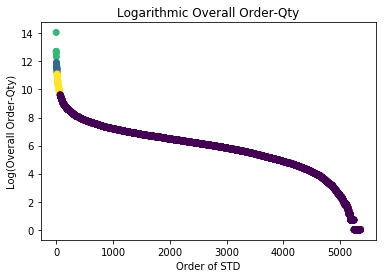

In [48]:
plt.scatter(range(len(df6)), np.log(df6.Order_Qty), c=df6.Class)
plt.xlabel('Order of STD')
plt.ylabel('Log(Overall Order-Qty)')
plt.title('Logarithmic Overall Order-Qty')

In [49]:
len(df6[df6.Class==3])

54

In [50]:
len(df6[df6.Class==2])

5

In [51]:
len(df6[df6.Class==1])

12

In [52]:
len(df6[df6.Class==0])

5289

In [53]:
################################################################## group Net_Value_item_level(Overall Value) by STD

In [54]:
df3 = df['Net_Value_item_level'].groupby(df['CustomerID']).sum()

In [55]:
df3 = df3.to_frame()

In [56]:
df3 = df3.reset_index()

In [57]:
df3.head()

,CustomerID,Net_Value_item_level
0,0000100002,9765.53
1,0000100004,48293.68
2,0000100005,18855.69
3,0000100006,160408.82
4,0000100007,55401.02


In [58]:
df3.describe()

,Net_Value_item_level
count,5.360000e+03
mean,4.929177e+04
std,4.868084e+05
min,0.000000e+00
25%,4.533235e+03
50%,1.233262e+04
75%,3.015384e+04
max,3.143766e+07


In [59]:
# exist Net_Value_item_level = 0, delete them
df3=df3.sort_values(by=["Net_Value_item_level"],ascending=[False])
len(df3[df3.Net_Value_item_level==0])

84

In [60]:
df3=df3[:-84]

In [61]:
# because the maximum value is much larger than the secondard largest value. To reduce the influence, I remove the largest value

In [62]:
X = np.array(df3.Net_Value_item_level.iloc[1:].reshape(-1,1))

C:\Users\Helen.Tian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


In [63]:
kmeans = KMeans(n_clusters = 3, random_state=0).fit(X)

In [64]:
Class=[]
Class.append(kmeans.labels_[0])
Class+=list(kmeans.labels_)

In [65]:
df4=df3.copy()

In [66]:
df4["Class"] = Class

Text(0.5,1,'Logarithmic Overall_Value')

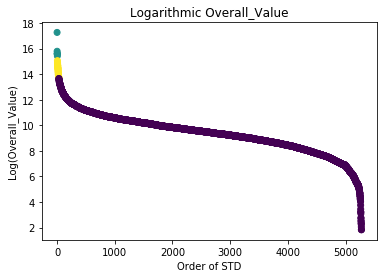

In [67]:
plt.scatter(range(len(df4)), np.log(df4.Net_Value_item_level), c=df4.Class)
plt.xlabel('Order of STD')
plt.ylabel('Log(Overall_Value)')
plt.title('Logarithmic Overall_Value')

In [68]:
len(df4[df4.Class==1])

6

In [69]:
len(df4[df4.Class==2])

25

In [70]:
len(df4[df4.Class==1])

6

In [71]:
len(df4[df4.Class==2])

25

In [72]:
################################################# Analysing diff percentage of product category in different Order_Qty STD

In [73]:
# Drinkware
dfD = df[df.ProductCategory=='Drinkware']

dfd = dfD['Order_Qty'].groupby(df['CustomerID']).sum()

dfd = dfd.to_frame()

dfd = dfd.reset_index()

In [74]:
# Soft Cooler
dfS = df[df.ProductCategory=='Soft Cooler']

dfs = dfS['Order_Qty'].groupby(df['CustomerID']).sum()

dfs = dfs.to_frame()

dfs = dfs.reset_index()

In [75]:
# Hard Cooler
dfH = df[df.ProductCategory=='Hard Cooler']

dfh = dfH['Order_Qty'].groupby(df['CustomerID']).sum()

dfh = dfh.to_frame()

dfh = dfh.reset_index()

In [76]:
# merge above dataframe together

DF=pd.merge(dfd, dfs,  on='CustomerID', how='outer')

DF=pd.merge(DF, dfh,  on='CustomerID', how='outer')

DF=DF.rename(index=str, columns={"CustomerID": "CustomerID", "Order_Qty_x": "DW_Qty","Order_Qty_y": "SK_Qty", "Order_Qty": "HK_Qty"})

DF=pd.merge(DF, df6,  on='CustomerID', how='outer')

DF=DF.fillna(0)


In [77]:
DF.head()

,CustomerID,DW_Qty,SK_Qty,HK_Qty,Order_Qty,Class
0,0000100002,84.0,2.0,44.0,130.0,0
1,0000100004,1622.0,97.0,98.0,1889.0,0
2,0000100005,240.0,10.0,75.0,484.0,0
3,0000100006,4712.0,124.0,303.0,5708.0,0
4,0000100007,822.0,189.0,54.0,1092.0,0


In [78]:
DF1 = DF.copy()
DF1['DW_Qty'] = DF.DW_Qty/DF.Order_Qty
DF1['SK_Qty'] = DF.SK_Qty/DF.Order_Qty
DF1['HK_Qty'] = DF.HK_Qty/DF.Order_Qty

In [79]:
DF1.head()

,CustomerID,DW_Qty,SK_Qty,HK_Qty,Order_Qty,Class
0,0000100002,0.646154,0.015385,0.338462,130.0,0
1,0000100004,0.858655,0.051350,0.051879,1889.0,0
2,0000100005,0.495868,0.020661,0.154959,484.0,0
3,0000100006,0.825508,0.021724,0.053083,5708.0,0
4,0000100007,0.752747,0.173077,0.049451,1092.0,0


In [80]:
qq=DF1.groupby('Class', as_index=False)['DW_Qty', 'SK_Qty', 'HK_Qty'].mean()
qq=qq.rename(index=str, columns={'DW_Qty':'Drinkware', 'SK_Qty': 'Soft Cooler', 'HK_Qty':'Hard Cooler'})
qq.Class = ['Small', 'Large', 'Medium','Extreme Large']
qq=qq.reindex(['0', '3', '1','2'])

In [81]:
qq

,Class,Drinkware,Soft Cooler,Hard Cooler
0,Small,0.729003,0.057316,0.136597
3,Extreme Large,0.886128,0.024192,0.029393
1,Large,0.903032,0.019534,0.032102
2,Medium,0.882652,0.024441,0.029995


C:\Users\Helen.Tian\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Text(0.5,1,'Average % of Order Quantity in different Class')

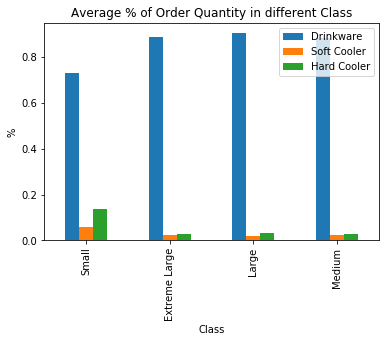

In [82]:
qq.plot(x='Class', y=['Drinkware', 'Soft Cooler', 'Hard Cooler'], kind="bar")
plt.ylabel('%')
plt.title('Average % of Order Quantity in different Class')

In [83]:
DF[(DF['Class']==3) | (DF['Class']==1)].head()

,CustomerID,DW_Qty,SK_Qty,HK_Qty,Order_Qty,Class
123,0000100169,17152.0,846.0,430.0,20147.0,3
133,0000100189,16378.0,523.0,123.0,17024.0,3
198,0000100283,22730.0,556.0,1152.0,32948.0,3
218,0000100315,91225.0,2287.0,5161.0,100365.0,1
243,0000100349,22844.0,2576.0,3156.0,29057.0,3


In [84]:
test=DF1[(DF1['Class']==3) | (DF1['Class']==1)]

In [85]:
test.head()

,CustomerID,DW_Qty,SK_Qty,HK_Qty,Order_Qty,Class
123,0000100169,0.851343,0.041991,0.021343,20147.0,3
133,0000100189,0.962054,0.030721,0.007225,17024.0,3
198,0000100283,0.689875,0.016875,0.034964,32948.0,3
218,0000100315,0.908932,0.022787,0.051422,100365.0,1
243,0000100349,0.786179,0.088653,0.108614,29057.0,3


Text(0.5,1,'Logarithmic Overall_Value')

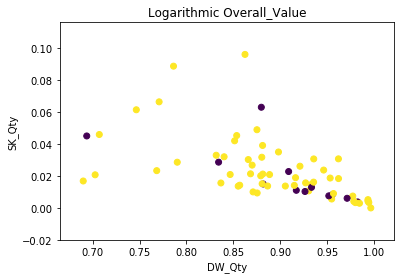

In [88]:
plt.scatter(x=test.DW_Qty, y= test.SK_Qty, c=test.Class)
plt.xlabel('DW_Qty')
plt.ylabel('SK_Qty')
plt.title('Logarithmic Overall_Value')